### SHOE CLASSIFICATION

In [1]:
from pathlib import Path
import pandas as pd
import os

# set the directory where the images are stored
direc = Path('C:/Users/chris/DSC680-T301/DSC680-T301/DSC680-T301/ut-zap50k-images')


# use glob to get all file paths with a .jpg extension
filepaths = list(direc.glob(r'**/**/**/*.jpg'))
img_df = pd.Series(filepaths, name='FilePaths').astype(str)
img_df = img_df.to_frame(name='FilePaths')


img_df['FileNames'] = img_df['FilePaths'].apply(lambda x: os.path.basename(x))
img_df['FolderName1'] = img_df['FilePaths'].apply(lambda x: os.path.dirname(x).split('\\')[-1])
img_df['FolderName2'] = img_df['FilePaths'].apply(lambda x: os.path.dirname(x).split('\\')[-2])
img_df['FolderName3'] = img_df['FilePaths'].apply(lambda x: os.path.dirname(x).split('\\')[-3])



In [2]:
img_df.head()

,FilePaths,FileNames,FolderName1,FolderName2,FolderName3
0,C:\Users\chris\DSC680-T301\DSC680-T301\DSC680-...,7965307.5291.jpg,A. Testoni,Ankle,Boots
1,C:\Users\chris\DSC680-T301\DSC680-T301\DSC680-...,7999255.363731.jpg,A. Testoni,Ankle,Boots
2,C:\Users\chris\DSC680-T301\DSC680-T301\DSC680-...,8000978.364150.jpg,A. Testoni,Ankle,Boots
3,C:\Users\chris\DSC680-T301\DSC680-T301\DSC680-...,8030969.3.jpg,adidas,Ankle,Boots
4,C:\Users\chris\DSC680-T301\DSC680-T301\DSC680-...,8030970.107722.jpg,adidas,Ankle,Boots


### Exploratory data analysis

In [4]:
from tabulate import tabulate

# Get the value counts for each class label
value_counts = img_df['FolderName3'].value_counts()

# Calculate the percentages
percentages = value_counts / len(img_df) * 100

# Create a table with the results
table = []
for i, label in enumerate(img_df['FolderName3'].unique()):
    table.append([i+1, label, value_counts[label], f'{percentages[label]:.2f}%'])

# Print the table
print(tabulate(table, headers=['Rank', 'Class Label', 'Count', 'Percentage']))

  Rank  Class Label      Count  Percentage
------  -------------  -------  ------------
     1  Boots            12832  25.65%
     2  Sandals           5741  11.48%
     3  Shoes            30169  60.31%
     4  Slippers          1283  2.56%


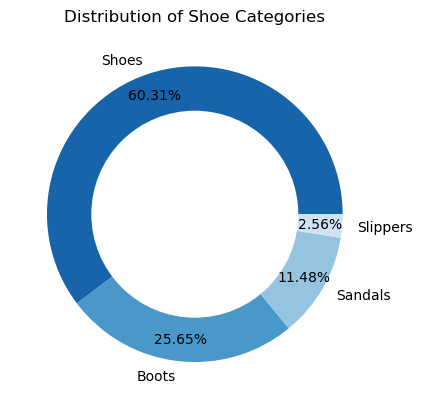

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for the donut chart
colors = sns.color_palette('Blues_r', len(img_df['FolderName3'].unique()))

# Create a figure and axes
fig, ax = plt.subplots()

# Create the donut chart
ax.pie(value_counts, labels=value_counts.index, colors=colors, autopct='%.2f%%', pctdistance=0.85, labeldistance=1.1)

# Add a circle at the center to create a donut chart
circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(circle)

# Set the title of the plot
plt.title('Distribution of Shoe Categories')

# Display the plot
plt.show()

### TRAIN AND VALIDATE THE IMAGES

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values between 0 and 1
    validation_split=0.2  # split data into training and validation sets
)

train_generator = datagen.flow_from_dataframe(
    dataframe=img_df,
    directory="C:/Users/chris/DSC680-T301/DSC680-T301/DSC680-T301/ut-zap50k-images",
    x_col="FilePaths",
    y_col="FolderName3",
    target_size=(128, 128),  # resize images to 128 x 128 pixels
    batch_size=32,
    subset="training"  # specify to use the training subset of data
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=img_df,
    directory="C:/Users/chris/DSC680-T301/DSC680-T301/DSC680-T301/ut-zap50k-images",
    x_col="FilePaths",
    y_col="FolderName3",
    target_size=(128, 128),
    batch_size=32,
    subset="validation"  # specify to use the validation subset of data
)




Found 40020 validated image filenames belonging to 4 classes.
Found 10005 validated image filenames belonging to 4 classes.


The ImageDataGenerator class from the Keras API creates image data generators for the training and validation subsets of the image dataset. The ImageDataGenerator class is used to preprocess the images, rescale the pixel values to be between 0 and 1, and split the data into the specified subsets. The flow_from_dataframe() method is used to load the image data from the dataframe and directory provided and yield batches of augmented data for training or validation. The images are resized to 128 x 128 pixels and loaded in batches of 32 images at a time.

### Convolutional Neural Network (CNN) model

In [21]:
# Define constants
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10


# Define and compile model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    verbose=1
)


Epoch 1/10
1251/1251 [==============================] - 624s 497ms/step - loss: 0.2678 - accuracy: 0.9073 - val_loss: 2.0283 - val_accuracy: 0.6838
Epoch 2/10
1251/1251 [==============================] - 638s 509ms/step - loss: 0.1492 - accuracy: 0.9456 - val_loss: 1.7923 - val_accuracy: 0.6478
Epoch 3/10
1251/1251 [==============================] - 627s 500ms/step - loss: 0.1052 - accuracy: 0.9610 - val_loss: 2.7296 - val_accuracy: 0.6567
Epoch 4/10
1251/1251 [==============================] - 604s 482ms/step - loss: 0.0734 - accuracy: 0.9726 - val_loss: 4.4869 - val_accuracy: 0.6159
Epoch 5/10
1251/1251 [==============================] - 605s 482ms/step - loss: 0.0482 - accuracy: 0.9830 - val_loss: 3.4985 - val_accuracy: 0.6701
Epoch 6/10
1251/1251 [==============================] - 607s 484ms/step - loss: 0.0338 - accuracy: 0.9879 - val_loss: 6.2442 - val_accuracy: 0.6159
Epoch 7/10
1251/1251 [==============================] - 607s 484ms/step - loss: 0.0253 - accuracy: 0.9908 - val_

In [22]:
val_loss, val_acc = model.evaluate(valid_generator)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

313/313 [==============================] - 43s 130ms/step - loss: 5.9386 - accuracy: 0.6717
Validation loss: 5.938570022583008
Validation accuracy: 0.6716641783714294


In [25]:
from tensorflow.keras.models import load_model
model.save("C:/Users/chris/DSC680-T301/DSC680-T301/DSC680-T301/model.h5")
model = load_model("C:/Users/chris/DSC680-T301/DSC680-T301/DSC680-T301/model.h5")


### VALIDATION WITH IMAGES

1/1 [==============================] - 3s 3s/step


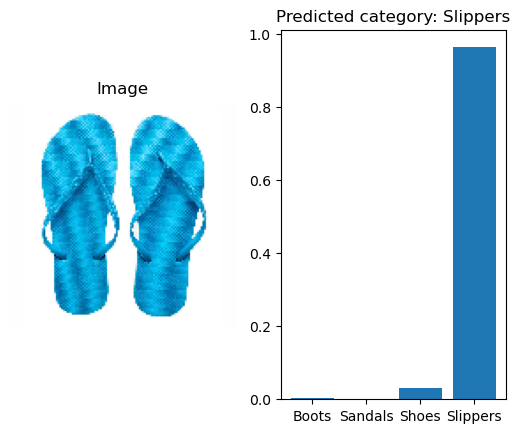

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('C:/Users/chris/DSC680-T301/DSC680-T301/DSC680-T301/model.h5')

# Load the image to be classified
img_path = 'C:/Users/chris/OneDrive/Desktop/Slipper.jpg'
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255.0

# Define the class labels
class_labels = pd.unique(img_df['FolderName3'])

# Make the prediction
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

# Display the image and predicted category
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].bar(class_labels, prediction[0])
ax[1].set_title('Predicted category: {}'.format(predicted_class))
plt.show()




1/1 [==============================] - 2s 2s/step


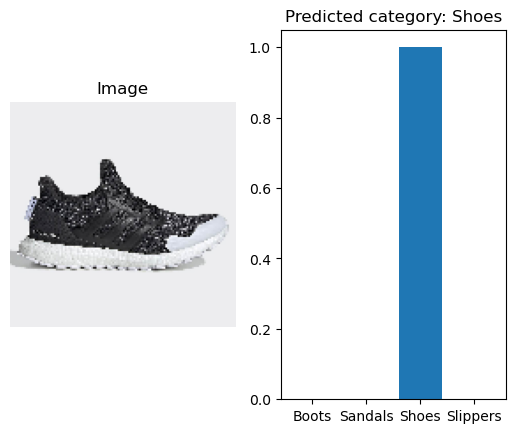

In [36]:
# Load the image to be classified
img_path = 'C:/Users/chris/OneDrive/Desktop/Adidas.jpg'
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255.0

# Define the class labels
class_labels = pd.unique(img_df['FolderName3'])

# Make the prediction
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

# Display the image and predicted category
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].bar(class_labels, prediction[0])
ax[1].set_title('Predicted category: {}'.format(predicted_class))
plt.show()
